### Import Libraries

In [5]:
import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib

# Package to implement ML Algorithms
import sklearn
from xgboost import XGBRegressor

# Import MAPIE to calculate prediction intervals
from mapie.regression import MapieRegressor

# To calculate coverage score
from mapie.metrics import regression_coverage_score

# Package for data partitioning
from sklearn.model_selection import train_test_split

# Package to record time
import time

# Module to save and load Python objects to and from files
import pickle 

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')

# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline

**Install MAPIE via `pip`**:

`!pip install mapie`

### Load Dataset

In [17]:
# Import Data
df = pd.read_csv('Traffic_Volume.csv')
df["date_time"] = pd.to_datetime(df["date_time"], format="%m/%d/%y %H:%M")

df["hour"] = df["date_time"].dt.hour
df["dayofweek"] = df["date_time"].dt.dayofweek
df["month"] = df["date_time"].dt.month
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)

# Drop the raw date column before concatenation
df = df.drop(columns=["date_time"])
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,traffic_volume,hour,dayofweek,month,is_weekend
0,NaN,288.28,0.0,0.0,40,Clouds,5545,9,1,10,0
1,NaN,289.36,0.0,0.0,75,Clouds,4516,10,1,10,0
2,NaN,289.58,0.0,0.0,90,Clouds,4767,11,1,10,0
3,NaN,290.13,0.0,0.0,90,Clouds,5026,12,1,10,0
4,NaN,291.14,0.0,0.0,75,Clouds,4918,13,1,10,0


In [18]:
# Select input and output features
X = df.drop(columns = ['traffic_volume'])
y = df['traffic_volume']


In [27]:
categorical_cols = ["holiday", "weather_main"]
cat_encoded = pd.get_dummies(X[categorical_cols], prefix=categorical_cols, drop_first=True)
X_encoded = pd.concat([X.drop(columns=categorical_cols), cat_encoded], axis=1)

X_encoded.head()

,temp,rain_1h,snow_1h,clouds_all,hour,dayofweek,month,is_weekend,holiday_Columbus Day,holiday_Independence Day,...,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm
0,288.28,0.0,0.0,40,9,1,10,0,False,False,...,True,False,False,False,False,False,False,False,False,False
1,289.36,0.0,0.0,75,10,1,10,0,False,False,...,True,False,False,False,False,False,False,False,False,False
2,289.58,0.0,0.0,90,11,1,10,0,False,False,...,True,False,False,False,False,False,False,False,False,False
3,290.13,0.0,0.0,90,12,1,10,0,False,False,...,True,False,False,False,False,False,False,False,False,False
4,291.14,0.0,0.0,75,13,1,10,0,False,False,...,True,False,False,False,False,False,False,False,False,False


In [28]:
# Data partitioning into train and test sets
train_X, test_X, train_y, test_y = train_test_split(X_encoded, y, test_size = 0.2, random_state = 42)

### Implement Random Forest Regressor

In [29]:
# Define your model
reg = XGBRegressor(random_state = 42)

In [30]:
# Fit the model
start = time.time()            # Start Time
reg.fit(train_X, train_y)  
stop = time.time()             # End Time
duration = round(stop - start, 2)
print(f"Training time: {duration}s")

Training time: 0.17s


#### Evaluate Prediction Performance on Test Set

In [31]:
# Predict Test Set
y_pred = reg.predict(test_X)

# Evaluate the model on test set
r2 = sklearn.metrics.r2_score(test_y, y_pred)
print('R-squared on Test Set: %0.2f' %r2)

RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, y_pred)
print('RMSE on Test Set: %0.2f' %RMSE_test)

R-squared on Test Set: 0.95
RMSE on Test Set: 429.04


#### Histogram of Residuals/Errors 

(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.,
        4500.]),
 [Text(0, 0.0, '0'),
  Text(0, 500.0, '500'),
  Text(0, 1000.0, '1000'),
  Text(0, 1500.0, '1500'),
  Text(0, 2000.0, '2000'),
  Text(0, 2500.0, '2500'),
  Text(0, 3000.0, '3000'),
  Text(0, 3500.0, '3500'),
  Text(0, 4000.0, '4000'),
  Text(0, 4500.0, '4500')])

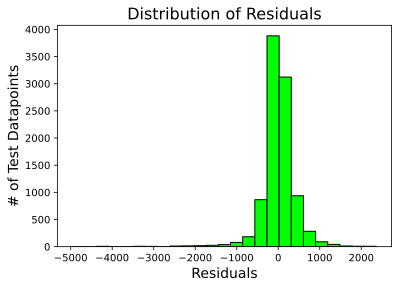

In [32]:
# Calculate the residuals by subtracting the predicted values from the actual test values
all_residuals = test_y - y_pred

# Set up the figure with custom size and resolution (DPI)
plt.figure(figsize=(6, 4), dpi = 150)

# Plot the histogram of residuals
plt.hist(all_residuals, bins = 25, color = 'lime', edgecolor = 'black')

# Label X and Y axes
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('# of Test Datapoints', fontsize = 14)

# Set the title of the plot
plt.title('Distribution of Residuals', fontsize = 16)

# Adjust the font size of x and y ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

#### Scatter Plot of Predicted Vs. Actual Values

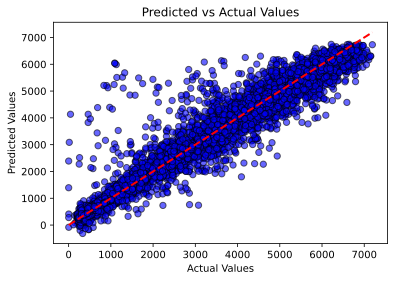

In [33]:
# Setting the figure size and resolution
plt.figure(figsize = (6, 4), dpi = 150)

# Scatter plot of actual vs predicted values
plt.scatter(test_y, y_pred, color = 'blue', alpha = 0.6, edgecolor = 'black', s = 40)

# 45-degree reference line (perfect predictions)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color = 'red', linestyle = '--', lw = 2)

# Axis labels and title
plt.xlabel('Actual Values', fontsize = 10)
plt.ylabel('Predicted Values', fontsize = 10)
plt.title('Predicted vs Actual Values', fontsize = 12)

# Adjust ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

#### Feature Importance Plot

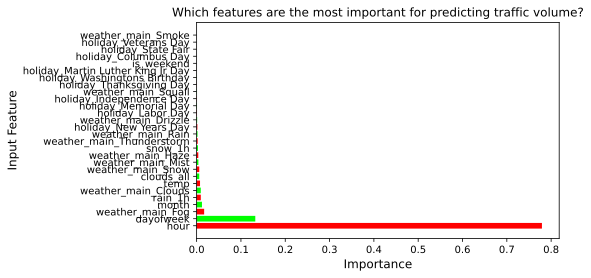

In [35]:
# Storing importance values from the trained model
importance = reg.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize=(8, 4))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['red', 'lime'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for predicting traffic volume?', fontsize = 12) 
plt.yticks(fontsize = 10) # fontsize of yticks
plt.xticks(fontsize = 10) # fontsize of xticks

plt.tight_layout();

### Prediction Intervals for Regression

#### **What is a Prediction Interval?**
- It is a **range of values** within which a new observation is expected to fall with a **certain probability**, given the existing data and model.

- **Probability**: The width of the prediction interval depends on the **desired confidence level**, (e.g., 95%), with higher confidence levels leading to wider intervals.

#### **Confidence Level of Prediction Interval**

- The confidence level of a prediction interval indicates the probability that the interval will contain the true value of the parameter being estimated.

- Mathematically, the confidence level of a prediction interval is denoted by $ (1 - \alpha) \times 100\% $, where $ \alpha $ is the significance level.

#### **Why Prediction Intervals are Useful?**

- **Uncertainty Quantification**: They provide a measure of the uncertainty in individual predictions, which is crucial for risk assessment and decision-making.

- **Communication**: They are an effective tool for communicating the uncertainty in predictions to stakeholders, making the model's predictions more interpretable.

#### **Prediction Intervals using MAPIE Regressor**

***MAPIE: Model Agnostic Prediction Interval Estimator***

- It is a Python library designed to estimate prediction intervals in a **model-agnostic way**.
- It can be used with **any machine learning model**, including linear models, decision trees, ensemble methods, and neural networks.

In [39]:
X_tr, X_cf, y_tr, y_cf = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

start = time.time()
reg.fit(X_tr, y_tr)
stop = time.time()
print(f"Base model training time: {stop - start:.3f}s")

mapie = MapieRegressor(estimator=reg, cv="prefit", n_jobs=-1)
mapie.fit(X_cf, y_cf)

# Predict point values and intervals on the test set
y_test_pred, y_test_pis = mapie.predict(test_X, alpha=.1)

# Extract lower/upper (shape is [n_samples, 2, n_alpha])
lower = y_test_pis[:, 0, 0]
upper = y_test_pis[:, 1, 0]

# Coverage (should be ~90%)
coverage = regression_coverage_score(test_y, lower, upper)
print(f"Empirical coverage: {coverage*100:.2f}%")



Base model training time: 0.127s
Empirical coverage: 90.49%


In [40]:
# Predicted values
y_test_pred

array([5847.17   , 2183.9636 ,  748.3937 , ..., 1915.9537 , 2865.3403 ,
        594.13934], shape=(9641,), dtype=float32)

In [41]:
# Prediction Intervals
y_test_pis

array([[[5270.27636719],
        [6424.06347656]],

       [[1607.07006836],
        [2760.85717773]],

       [[ 171.50012207],
        [1325.28723145]],

       ...,

       [[1339.06018066],
        [2492.84729004]],

       [[2288.44677734],
        [3442.23388672]],

       [[  17.24578857],
        [1171.03289795]]], shape=(9641, 2, 1))

In [42]:
# Storing results in a dataframe
predictions = test_y.to_frame()
predictions.columns = ['Actual Value']
predictions["Predicted Value"] = y_test_pred.round(2)
predictions["Lower Value"] = y_test_pis[:, 0].round(2)
predictions["Upper Value"] = y_test_pis[:, 1].round(2)

# Take a quick look
predictions.tail(5)

,Actual Value,Predicted Value,Lower Value,Upper Value
6401,2491,2701.379883,2124.48,3278.27
34004,5251,5270.049805,4693.16,5846.94
46086,2224,1915.949951,1339.06,2492.85
42579,2928,2865.340088,2288.45,3442.23
23709,910,594.140015,17.25,1171.03


### **Coverage Calculation**
- **Coverage** refers to the proportion of true/actual values that fall within the prediction intervals generated by a model.

- It is a measure of how well the prediction intervals capture the actual values.

  $\text{Coverage} = \frac{\text{Number of actual values within prediction intervals}}{\text{Total number of actual values}}$

In [ ]:
lower = y_test_pis[:, 0, 0]
upper = y_test_pis[:, 1, 0]

coverage = regression_coverage_score(test_y, lower, upper)
coverage_percentage = float(coverage) * 100
print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 90.49%


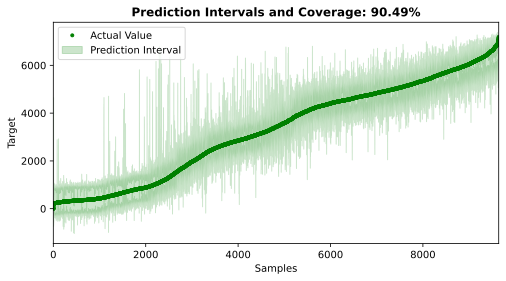

In [45]:
# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with green dots
plt.plot(sorted_predictions["Actual Value"], 'go', markersize=3, label="Actual Value")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent green color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="green", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10);

### Save Model

In [46]:
# Creating the file where we want to write the model
reg_pickle = open('traffic_model.pickle', 'wb') 

# Write RF model to the file
pickle.dump(mapie, reg_pickle) 

# Close the file
reg_pickle.close()